<a href="https://colab.research.google.com/github/jesusgl86/Deep-Learning-Course/blob/main/M2H857.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install setuptools==66.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.4 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.6.0
    Uninstalling setuptools-67.6.0:
      Successfully uninstalled setuptools-67.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.


In [3]:
!pip install d2l==1.0.0-beta0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.6/141.6 KB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 30.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 KB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 KB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.9/120.9 KB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 47.7 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for gym
  Running setup.py clean 

In [4]:
import torch
from torch import nn
from d2l import torch as d2l
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # Use is_grad_enabled to determine whether we are in training mode
    if not torch.is_grad_enabled():
        # In prediction mode, use mean and variance obtained by moving average
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # When using a fully connected layer, calculate the mean and
            # variance on the feature dimension
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # When using a two-dimensional convolutional layer, calculate the
            # mean and variance on the channel dimension (axis=1). Here we
            # need to maintain the shape of X, so that the broadcasting
            # operation can be carried out later
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # In training mode, the current mean and variance are used
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # Update the mean and variance using moving average
        moving_mean = (1.0 - momentum) * moving_mean + momentum * mean
        moving_var = (1.0 - momentum) * moving_var + momentum * var
    Y = gamma * X_hat + beta  # Scale and shift
    return Y, moving_mean.data, moving_var.data
class BatchNorm(nn.Module):
    # num_features: the number of outputs for a fully connected layer or the
    # number of output channels for a convolutional layer. num_dims: 2 for a
    # fully connected layer and 4 for a convolutional layer
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # The scale parameter and the shift parameter (model parameters) are
        # initialized to 1 and 0, respectively
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # The variables that are not model parameters are initialized to 0 and
        # 1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # If X is not on the main memory, copy moving_mean and moving_var to
        # the device where X is located
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # Save the updated moving_mean and moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.1)
        return Y
class BNLeNetScratch(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5), BatchNorm(6, num_dims=4),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), BatchNorm(16, num_dims=4),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(), nn.LazyLinear(120),
            BatchNorm(120, num_dims=2), nn.Sigmoid(), nn.LazyLinear(84),
            BatchNorm(84, num_dims=2), nn.Sigmoid(),
            nn.LazyLinear(num_classes))        

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


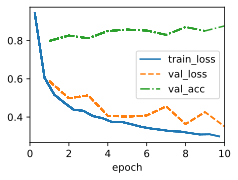

In [5]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = BNLeNetScratch(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

In [6]:
model.net[1].gamma.reshape((-1,)), model.net[1].beta.reshape((-1,))

(tensor([1.9657, 1.8227, 1.5497, 1.6436, 1.3149, 2.3707],
        grad_fn=<ReshapeAliasBackward0>),
 tensor([-1.4374, -0.3600,  0.8875, -0.5433,  0.8161,  1.2471],
        grad_fn=<ReshapeAliasBackward0>))

In [7]:
class BNLeNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5), nn.LazyBatchNorm2d(),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.LazyBatchNorm2d(),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(), nn.LazyLinear(120), nn.LazyBatchNorm1d(),
            nn.Sigmoid(), nn.LazyLinear(84), nn.LazyBatchNorm1d(),
            nn.Sigmoid(), nn.LazyLinear(num_classes))

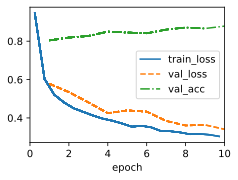

In [8]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = BNLeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

In [9]:
class LeNet(d2l.Classifier):  #@save
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))
@d2l.add_to_class(d2l.Classifier)  #@save
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet()
model.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


In [12]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
X, y = next(iter(data.val_dataloader()))

     

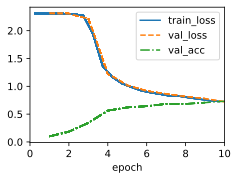

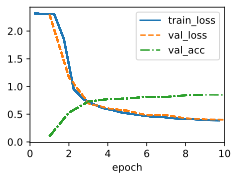

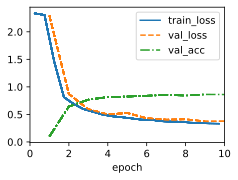

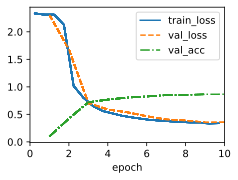

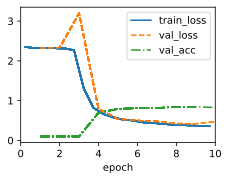

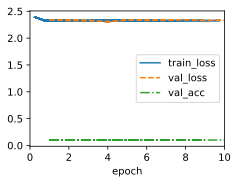

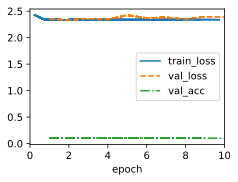

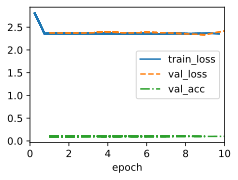

In [20]:
import numpy as np
AccuracyLeNet=np.zeros(8)
lr=[.1, 1, 2, 4, 6, 8, 10, 12]
for i in range(8):
  model = LeNet(lr[i])
  model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
  trainer.fit(model, data)
  yhat=model(X)
  AccuracyLeNet[i]=model.accuracy(yhat,y)

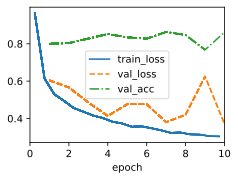

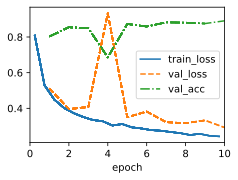

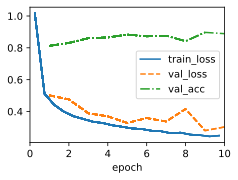

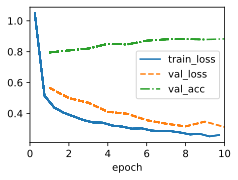

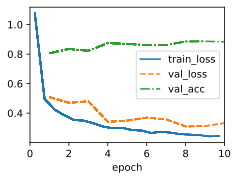

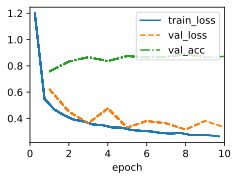

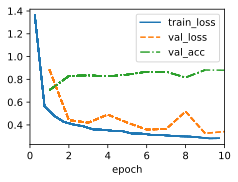

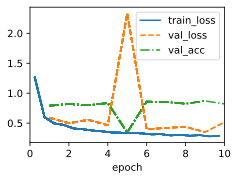

In [21]:
import numpy as np
AccuracyBNLeNet=np.zeros(8)
lr=[.1, 1, 2, 4, 6, 8, 10, 12]
for i in range(8):
  model = BNLeNet(lr[i])
  model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
  trainer.fit(model, data)
  yhat=model(X)
  AccuracyBNLeNet[i]=model.accuracy(yhat,y)

In [22]:
print(AccuracyLeNet)
print(AccuracyBNLeNet)

[0.765625  0.8515625 0.890625  0.8515625 0.8359375 0.09375   0.1328125
 0.078125 ]
[0.90625   0.8828125 0.8828125 0.84375   0.890625  0.875     0.859375
 0.828125 ]


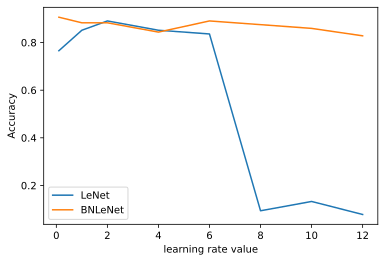

In [24]:
import matplotlib.pyplot as plt
plt.plot(lr,AccuracyLeNet)
plt.plot(lr,AccuracyBNLeNet)
plt.gca().legend(('LeNet','BNLeNet'))
plt.ylabel('Accuracy')
plt.xlabel('learning rate value')
plt.show()

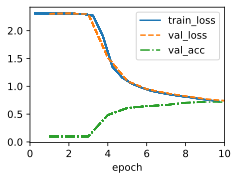

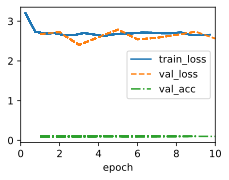

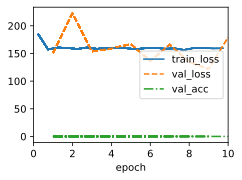

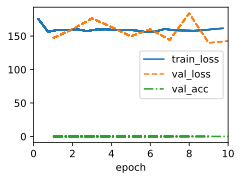

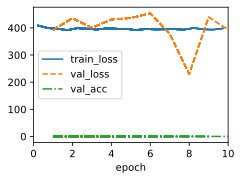

In [30]:
import numpy as np
AccuracyLeNet2=np.zeros(5)
lr=[.1, 20, 40, 60, 80]
for i in range(5):
  model = LeNet(lr[i])
  model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
  trainer.fit(model, data)
  yhat=model(X)
  AccuracyLeNet2[i]=model.accuracy(yhat,y)

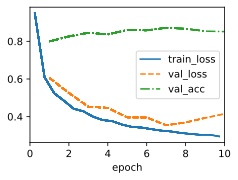

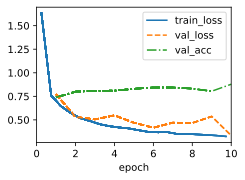

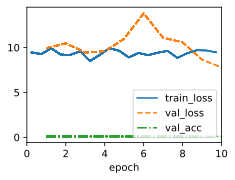

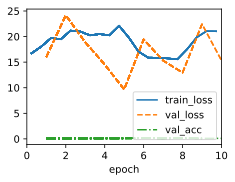

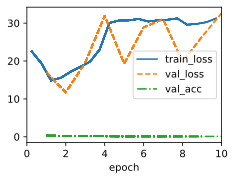

In [34]:
import numpy as np
AccuracyBNLeNet2=np.zeros(5)
lr=[.1, 20, 40, 60, 80]
for i in range(5):
  model = BNLeNet(lr[i])
  model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
  trainer.fit(model, data)
  yhat=model(X)
  AccuracyBNLeNet2[i]=model.accuracy(yhat,y)

In [35]:
print(AccuracyLeNet2)
print(AccuracyBNLeNet2)

[0.75     0.078125 0.078125 0.09375  0.125   ]
[0.859375  0.8828125 0.1171875 0.1171875 0.1015625]


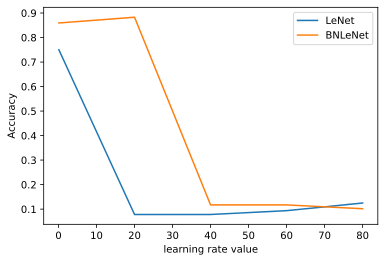

In [36]:
import matplotlib.pyplot as plt
plt.plot(lr,AccuracyLeNet2)
plt.plot(lr,AccuracyBNLeNet2)
plt.gca().legend(('LeNet','BNLeNet'))
plt.ylabel('Accuracy')
plt.xlabel('learning rate value')
plt.show()

In [37]:
class BNLeNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5), nn.LazyBatchNorm2d(),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(), nn.LazyLinear(120),
            nn.Sigmoid(), nn.LazyLinear(84), nn.LazyBatchNorm1d(),
            nn.Sigmoid(), nn.LazyLinear(num_classes))

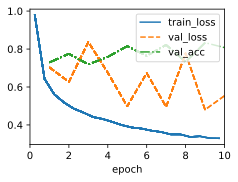

In [38]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = BNLeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)